In [15]:
%matplotlib inline

In [16]:
import glob
import sys
import numpy as np
import matplotlib.colorbar
import calculate_rmsd as rmsd
from numpy import *
from numpy.linalg import eig
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import pairwise_distances

In [17]:
def ReadFile(f):
    """ Reads in each file, and for each file, separates each IRC point into its own matrix of cartesian coordinates.
    coordinates_all is arranged as coordinates_all[n][N][c], where n is the IRC point, N is the atom number, and c
    is the x, y, or z cordinate.
    """
    print("File: %s" % f)
    name = f.split('/')[-1].split('.')[-2]
   
    xyz = open(f)
    n_atoms = int(xyz.readline())
    energies = []
    atoms = []
    coordinates = []
   
    ###Each point along the IRC/traj will be stored as an entry in a 3D array called coordinates_all
    coordinates_all = []
    for line in xyz:
        splitline=line.split()
        if len(splitline)==4:
            atom,x,y,z = line.split()
            atoms.append(atom)
            coordinates.append([float(x), float(y), float(z)])
        elif len(splitline)==1:
            if float(splitline[0])==float(n_atoms):
                pass
            else:
                energy = float(splitline[0])
                energies.append(energy)
            if len(coordinates) != 0:
                coordinates_all.append(coordinates)
            elif len(coordinates) == 0:
                pass
            atoms = []
            coordinates = []
    else:
        coordinates_all.append(coordinates)

    xyz.close()

    coordinates_all = np.asarray(coordinates_all)
    n_ircpoints=len(coordinates_all)

    ###Print ERROR if length of coordinate section doesn't match number of atoms specified at beginning of xyz file
    if len(atoms) != n_atoms:
        print("ERROR: file contains %d atoms instead of the stated number %d" % (n_atoms, len(atoms)))
        print("number of atoms in file: %d" % len(atoms))
        print("number of coordinates:   %d" % len(coordinates))

    return(name,energies,atoms,coordinates_all)

In [18]:
def SetAtomOnetoOrigin(coordinates):
    coordinates_shifted = coordinates - coordinates[:,np.newaxis,0]

    return(coordinates_shifted)

In [19]:
def MassWeighting(atoms,coordinates):    

    masses={"H" : 1.0079, "He": 4.003, "Li" : 6.941, "Be" : 9.012, "B" : 10.811, "C" : 12.0107, "N" : 14.0067, 
            "O" : 15.9994, "F" : 18.9984, "Ne" : 20.18, "Na" : 22.99, "Mg" : 24.305, "Al" : 26.982, "Si" : 28.086,
            "P" : 30.974, "S" : 32.065, "Cl" : 35.453, "Ar" : 39.948, "K" : 39.098, "Ca" : 40.078, "Sc" : 44.956,
            "Ti" : 47.867, "V" : 50.942, "Cr" : 51.996, "Mn" : 54.938, "Fe" : 55.845, "Co" : 58.933, "Ni" : 58.693,
            "Cu" : 63.546, "Zn" : 65.39, "Ga" : 69.723, "Ge" : 72.64, "As" : 74.922, "Se" : 78.96, "Br" : 79.904, 
            "Kr" : 83.8, "Rb" : 85.468, "Sr" : 87.62, "Y" : 88.906, "Zr" : 91.224, "Nb" : 92.906, "Mo" : 95.94,
            "Tc" : 98, "Ru" : 101.07, "Rh" : 102.906, "Pd" : 106.42, "Ag" : 107.868, "Cd" : 112.411, "In" : 114.818,
            "Sn" : 118.71, "Sb" : 121.76, "Te" : 127.6, "I" : 126.905, "Xe" : 131.293, "Cs" : 132.906, "Ba" : 137.327,
            "La" : 138.906, "Ce" : 140.116, "Pr" : 140.908, "Nd" : 144.24, "Pm" : 145, "Sm" : 150.36, "Eu" : 151.964, 
            "Gd" : 157.25, "Tb" : 158.925, "Dy" : 162.5, "Ho" : 164.93, "Er" : 167.29, "Tm" : 168.934, "Yb" : 173.04,
            "Lu" : 174.967, "Hf" : 178.49, "Ta" : 180.948, "W" : 183.84, "Re" : 186.207, "Os" : 190.23, "Ir" : 192.217,
            "Pt" : 195.078, "Au" : 196.967, "Hg" : 200.59, "Tl" : 204.383, "Pb" : 207.2, "Bi" : 208.98, "Po" : 209,
            "At" : 210, "Rn" : 222, "Fr" : 223, "Ra" : 226, "Ac" : 227, "Th" : 232.038, "Pa" : 231.036, "U" : 238.029,
            "Np" : 237, "Pu" : 244, "Am" : 243, "Cm" : 247, "Bk" : 247, "Cf" : 251, "Es" : 252, "Fm" : 257, "Md" : 258, 
            "No" : 259, "Lr" : 262, "Rf" : 261, "Db" : 262, "Sg" : 266, "Bh" : 264, "Hs" : 277, "Mt" : 268}
    
    atom_masses=[]
    for atom in atoms:
        atom_mass = masses[atom]
        atom_masses.append(atom_mass)
        
    weighting = np.sqrt(atom_masses)
    weighting_tri = np.column_stack((weighting,weighting,weighting))
    
    mass_weighted_coords = coordinates*weighting_tri[np.newaxis, :, :]

    return(masses,atom_masses,mass_weighted_coords)

In [20]:
### Generate distance matrices to represent each structure
def GenDs(coordinates):
    """ Generates distance matrices, either for each structure or between structures, depending on the input.
    """
    D = np.sqrt(np.sum((coordinates[:,:,None] - coordinates[:,None,:])**2, axis=3))
    D2 = np.sum((coordinates[:,:,None] - coordinates[:,None,:])**2, axis=3)
    return(D2)

#%timeit GenDs()
#np.allclose(GenDs(),np.sqrt(np.sum((c[:,:,None] - c[:,None,:])**2, axis=3)))

In [21]:
def ReshapeAllDs(D):
    """ Takes only the upper triangle of the distance matrices and reshapes them into 1D arrays.
    """
    D_re = []
    x = D[0][0].shape[0]

    for Dint in D:
        Dint_re = Dint[np.triu_indices(x,k=1)]
        D_re.append(Dint_re)
        
    D_re = np.asarray(D_re)
        
    return D_re

In [22]:
def CalcMean(v):
    """ Calculates mean vector (in case of doing DR, all structures are centered around the mean). 
    """
    mean_v=np.mean(v,axis=0)

    ### Center all points around mean by explicitly subtracting mean distance matrix
    mean_centered_vs=[]
    for i in range(len(v)):
        mean_centered_vs.append(v[i]-mean_v)
    
    mean_centered_vs = np.array(mean_centered_vs)
    return(mean_v,mean_centered_vs)

In [23]:
def SVD(D):
    """ Calculate singular values of some distance matrix, D. 
    """
    #u, w, vh = np.linalg.svd(D, full_matrices=True)
    u, w, vh = np.linalg.svd(D)
    
    ### Shapes of matrices in SVD
    print("u shape: %s" % str(u.shape))
    print("w shape: %s" % str(w.shape))
    print("vh shape: %s" % str(vh.shape))
    
    ###Sort eigenvalues in descending order (though I believe this occurs by default)
    idx = w.argsort()[::-1] 
    u = u[:,idx]
    w = w[idx]
    vh = vh[idx,:]
    
    assert np.allclose(D, np.dot(u, np.dot(np.diag(w), vh)))
    
    return(u,w,vh)

In [24]:
def vector_to_matrix(v):
    """ Converts a representation from 1D vector to 2D square matrix.
    :param v: 1D input representation.
    :type v: numpy array 
    :return: Square matrix representation.
    :rtype: numpy array 
    """
    if not (np.sqrt(8*v.shape[0]+1) == int(np.sqrt(8*v.shape[0]+1))):
        print("ERROR: Can not make a square matrix.")
        exit(1)

    n = v.shape[0]
    l = ((-1 + int(np.sqrt(8*n+1)))//2)+1
    M = np.zeros((l,l))

    index = 0
    for i in range(l):
        for j in range(l):
            if i > j-1:
                continue

            M[i,j] = v[index]
            M[j,i] = M[i,j]

            index += 1
    return M

In [25]:
def DistanceMatrixtoCoords(D):
    """ Converts a (2D square) distance matrix representation to Cartesian coordinates (first 3 columns correspond 
    to 3D xyz coordinates) via a Gram matrix.
    :param D: 2D square matrix.
    :type D: numpy array 
    :return: 3D Cartesian coordinates.
    :rtype: numpy array 
    """
    M=np.zeros((D.shape[0],D.shape[1]))
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            #M[i,j] = 0.5*(np.square(D[0,j]) + np.square(D[i,0]) - np.square(D[i,j]))
            M[i,j] = 0.5*(D[0,j] + D[i,0] - D[i,j])
            
    values,vectors = np.linalg.eig(M)
    
    idx = values.argsort()[::-1] 
    values = values[idx]
    vectors = vectors[:,idx]
    
    assert np.allclose(np.dot(M,vectors), values*vectors)
    
    coords = np.dot(vectors,np.diag(np.sqrt(values)))
    coords = np.asarray(coords)
    
    return(coords)

In [26]:
def DistanceMatrixtoCoords_new(D):
    """ Converts a (2D square) distance matrix representation to Cartesian coordinates (first 3 columns correspond 
    to 3D xyz coordinates) via a Gram matrix (NEW DEFINITION OF M).
    :param D: 2D square matrix.
    :type D: numpy array 
    :return: 3D Cartesian coordinates.
    :rtype: numpy array 
    """
    M=-0.5*(D-np.ones(D.shape[0])*np.transpose(D[:,0]) - D[:,0]*np.transpose(np.ones(D.shape[0])))
            
    values,vectors = np.linalg.eig(M)
    
    idx = values.argsort()[::-1] 
    values = values[idx]
    vectors = vectors[:,idx]
    
    assert np.allclose(np.dot(M,vectors), values*vectors)
    
    coords = np.dot(vectors,np.diag(np.sqrt(values)))
    coords = np.asarray(coords)
    
    return(coords)

In [27]:
import numpy as np
D=np.diag((1,2,3,4,5,6))
print(D.shape)
print(np.dot(np.ones(D.shape[0]),np.transpose(D[:,1])))

(6, 6)
2.0


In [28]:
def ReducedDimensionalD(u,w,vh,ndim):
    wred=np.zeros((w.shape[0],w.shape[0]))
    for i in range(ndim):
        wred[i,i]=w[i]
    
    Dred = np.dot(u, np.dot(wred, vh))
    
    return(Dred)

In [29]:
def PrincipalCoords(mean_D,u,w,vh,ndim,atom_masses,MWornot):
    """ Get coordinates back that correspond to motion along principal coordinates. First, use u, w, and  generated
    by SVD function to construct principal coordinates in terms of distance matrices and then convert distance 
    matrices back into Cartesians using DistanceMatrixtoCoords.
    :param u: 2D square matrix (output from SVD).
    :param w: 1D array (output from SVD).
    :param vh: 2D square matrix (output from SVD).
    :type u, w, vh: numpy array 
    :return: xyz_coords- xyz coordinates of structures along each Xi
    :rtype: numpy arrays 
    """
    
    X = []
    X_plus_means = []
    xyz_coords_all = []
    for i in range(ndim):
        wred = np.zeros((w.shape[0],w.shape[0]))
        wred[i,i] = w[i]
    
        X.append(np.dot(u, np.dot(wred, vh)))
        
        #X_Ds = [X[i][j] + mean_D for j in range(len(X[i]))]
        X_Ds = X[i] + mean_D[np.newaxis,:] 
        X_Ds = np.array(X_Ds)
        
        X_plus_means.append(X_Ds)
        
        # Turning each distance vector into distance matrix and converting that distance matrix into 
        # Cartesian coordinates
        coords_Dmat_all = []
        coords_all = []
        xyz_coords = []
        for k in range(X_Ds.shape[0]):
            coords_Dmat = vector_to_matrix(X_Ds[k])
            coords_Dmat_all.append(coords_Dmat)
            coords = DistanceMatrixtoCoords(coords_Dmat)
            coords_all.append(coords)
            
            # Only taking points in first three columns as xyz coordinates 
            xyz_coords_l = coords[:,0:3]
            xyz_coords.append(xyz_coords_l)
        
        xyz_coords_all.append(xyz_coords)
        
    xyz_coords_all=np.array(xyz_coords_all).real
    
    if MWornot == "MW":
        weighting = np.sqrt(atom_masses)
        weighting_tri = np.column_stack((weighting,weighting,weighting))

        unmass_weighted_xyz_coords=xyz_coords_all/weighting_tri[np.newaxis, np.newaxis, :, :]

    elif MWornot == "noMW":
        unmass_weighted_xyz_coords=xyz_coords_all
    
    return(X, X_plus_means, coords_Dmat_all, unmass_weighted_xyz_coords)

In [30]:
def Kabsch(coords):
    """Kabsch algorithm to get orientation of axes that minimizes RMSD (to avoid rotations in visualization).
    """
    coords[0] -= rmsd.centroid(coords[0])
    coords_Kabsch=[]
    for i in range(len(coords)):
        coords[i] -= rmsd.centroid(coords[i])
        coords_Kabschi = rmsd.kabsch_rotate(coords[i][:,np.newaxis], coords[0][:,np.newaxis])
        coords_Kabsch.append(coords_Kabschi)

    return(coords_Kabsch)

In [31]:
def Reorient(start,atoms,coords):
    """Reorient regenerated structures via rotations and reflections (NOTE: THIS WILL AFFECT CHIRALITY).
    Kabsch algorithm is used to get orientation of axes that minimizes RMSD.
    """
    start -= rmsd.centroid(start)
    axes_swap=[]
    axes_reflect=[]
    for i in range(len(coords)):
        coords[i] -= rmsd.centroid(coords[i])
        coords[i] = rmsd.kabsch_rotate(coords[i], start)
        min_rmsd, min_swap, min_reflection, min_review = rmsd.check_reflections(atoms, atoms, coords[i], start, reorder_method=None)
        axes_swap.append(min_swap)
        axes_reflect.append(min_reflection)
        coords[i][:,[0,1,2]] = coords[i][:,min_swap]
        coords[i] = coords[i]*min_reflection
        coords[i] = rmsd.kabsch_rotate(coords[i], coords[0])

    return(axes_swap,coords)

In [32]:
def MakeCoordFiles(name,atoms,xyz_coords):
    """ Save principal coordinates as xyz files coord[n].xyz to working directory.
    :param xyz_coord1: xyz coordinates of structures along X1.
    :param xyz_coord2: xyz coordinates of structures along X2.
    :type xyz_coord1, xyz_coord2: lists of numpy arrays
    """
    
    for k in range(np.array(xyz_coords).shape[0]):
        f=open('%s_coord%s.xyz' % (name,k+1),'w')
            
        for i in range(len(xyz_coords[k])):
            
            a=xyz_coords[k][i]
            a=a.tolist()
            b=[]
            for j in range(len(a)):
                a[j] = [ '%.5f' % x for x in a[j] ]
                a[j].insert(0,atoms[j])
                b.append(a[j])

            f.write('%d' % len(atoms) + '\n')
            f.write('%s point %i' % (name,i+1) + '\n')
            f.write('%s' % str(np.asarray(b)).replace("[","").replace("]","").replace("'","") + '\n')

        f.close()

In [33]:
def GoF(w,ndim):
    """ Calculate "goodness of fit" by determining how much of the variance (sum of w's) is described by the singular
    values used.
    """
    GoF=np.zeros((ndim+1,1))
    x=0
    for k in range(ndim):
        x=x+w[k]/np.sum(w)
        GoF[k]=x
    
        print("Goodness of fit (%s-dim)= %f" % (k+1,GoF[k]))
    
    return(GoF)

### Calcuation of stress by taking distance between reduced D and full D###
def Stress(D,Dred,ndim):
    """ Calculate "stress" by determining how far the reconstructed points are from the original points.
    """
    stress=np.sum(np.square(Dred-D))/np.sum(np.square(D))
    print("Stress (%s-dim) = %f" % (ndim,stress))
    
    return(stress)

In [34]:
def PlotResults(u,w,energies,name,ndim,MWornot):
    if MWornot == "MW":
        units = "Bohr$\sqrt{amu}$"
    elif MWornot == "noMW":
        units = "Bohr"
        
    fig=plt.figure(figsize=(15, 4))
    
    wred=np.zeros((w.shape[0],w.shape[0]))
    for i in range(ndim):
        wred[i,i]=w[i]
    
    ### z direction is energy relative to reactant
    if energies[-1]>energies[0]:
        z=[(i-energies[-1])*627.51 for i in energies]
    else:
        z=[(i-energies[0])*627.51 for i in energies]
    
    Xs=(np.dot(u, wred))
    for i in range(ndim):
        x = Xs[:,i].real
        if i == 0:
            ax=fig.add_subplot(1,ndim,i+1)
            cb = ax.scatter(x, z, c=z, cmap='gnuplot2',edgecolors='k')
            ax.set_xlabel("$\chi_1$ (%s)" % units, fontsize=12)
            ax.set_ylabel("Relative Energy (kcal/mol)", fontsize=12)
            fig.colorbar(cb,ax=ax)
        elif i == 1:
            ax=fig.add_subplot(1,ndim,i+1)
            ax.scatter(Xs[:,0], x, c=z, cmap='gnuplot2',edgecolors='k')
            ax.set_xlabel("$\chi_1$ (%s)" % units, fontsize=12)
            ax.set_ylabel("$\chi_2$ (%s)" % units, fontsize=12)
            fig.colorbar(cb,ax=ax)
        elif i == 2:
            ax=fig.add_subplot(1,ndim,i+1, projection='3d')
            ax.scatter(Xs[:,0],Xs[:,1],x,c=z,cmap='gnuplot2',edgecolors='k',marker='o')
            ax.set_xlabel("$\chi_1$ (%s)" % units, fontsize=12)
            ax.set_ylabel("$\chi_2$ (%s)" % units, fontsize=12)
            ax.set_zlabel("$\chi_3$ (%s)" % units, fontsize=12)
            ax.view_init(elev=20., azim=50)
            fig.colorbar(cb,ax=ax)
    
    fig.tight_layout()
    
    fig.savefig('%s_%sDim_plots.png'% (name,ndim))
    
    return(Xs,cb)

    Functions specific to doing CMDS the "OLD WAY"

In [35]:
def DistanceMatrix(mass_weighted_coords_all,mean_centered_mwcs):
    D = pairwise_distances(mass_weighted_coords_all)
    D2 = np.square(D)
    mean_centered_mwcs=np.reshape(mean_centered_mwcs,(len(mean_centered_mwcs),len(mean_centered_mwcs[0])))
    D_mean = pairwise_distances(mean_centered_mwcs)
    D_mean2 = np.square(D_mean)
    
    return(D_mean2)

In [36]:
### Center all points around mean using centering matrix: J = E - n^(-1)1
def CenteringMatrix(coordinates_all):    
    J = np.identity(len(coordinates_all)) - len(coordinates_all)**(-1)*1
    return(J)

In [37]:
### Generate inner product matrix B = -(1/2)J*D2*Jt
def InnerProductMatrix(J,D_mean2):
    B = (-0.5)*np.dot(J,np.dot(D_mean2,np.transpose(J)))
    return(B)

In [38]:
def EigenDecomposition(B):
    values,vectors = eig(B)
    
    ###Sort eigenvalues in descending order
    idx = values.argsort()[::-1] 
    values = values[idx]
    vectors = vectors[:,idx]
    
    return(values,vectors)

In [52]:
def Strain(values,vectors,B,ndim):
    sdenom = 0.0
    snum = 0.0
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            sdenom = sdenom + B[i,j]*B[i,j]
            xdot = 0.0
            for k in range(ndim):
                xdot = xdot + values[k]*vectors[i,k]*vectors[j,k]
            snum = snum + (B[i,j] - xdot)**2
    
    strain = np.sqrt(snum/sdenom)
    
    print("Strain (%s-dim) = %f" % (ndim,strain))
    
    return(strain)

In [39]:
def PrincipalCoords_Old(masses,values,vectors,mean_centered_mwcs,coordinates_all):
    mean_centered_mwcs = np.reshape(mean_centered_mwcs,(mean_centered_mwcs.shape[0],mean_centered_mwcs.shape[1]))
    vectorsT = np.transpose(vectors)
    result = np.matmul(vectorsT,mean_centered_mwcs)
    resultT = np.transpose(result)
    
    ### Divide each column by square root of λ
    div1 = resultT/np.sqrt(values)[np.newaxis,:]
    
    masses = np.column_stack((masses,masses,masses))
    masses = np.reshape(masses,(3*masses.shape[0],1))
    
    ### Divide each row by square root of atomic mass
    div2 = div1/np.sqrt(masses)

    TSS = np.reshape(coordinates_all[0],(3*len(coordinates_all[0]),1))
    
    coord1 = np.reshape(div2[:,0].real,(len(div2[:,0]),1))
    coord2 = np.reshape(div2[:,1].real,(len(div2[:,1]),1))
    
    ### Normalize principal coordinates
    coord1_norm = coord1 / np.sqrt((np.sum(coord1**2)))
    coord2_norm = coord2 / np.sqrt((np.sum(coord2**2)))

    ### Adding multiples of first principal coordinate to TSS
    coord1_all=[]
    for i in range(-30,30):
        coord1i=TSS+(i*(coord1_norm)/10)
        coord1_all.append(coord1i)

    for i in range(0,len(coord1_all)):
        coord1_all[i]=np.reshape(coord1_all[i],(int(len(coord1_all[i])/3),3))
    
    ### Adding multiples of second principal coordinate to TSS
    coord2_all=[]
    for i in range(-30,30):
        coord2i=TSS+(i*(coord2_norm)/10)
        coord2_all.append(coord2i)

    for i in range(0,len(coord2_all)):
        coord2_all[i]=np.reshape(coord2_all[i],(int(len(coord2_all[i])/3),3))
        
    coords_all=[]
    coords_all.append(coord1_all)
    coords_all.append(coord2_all)
        
    return(coords_all)

In [46]:
def Old_Way(file,ndim):
    print("\nOLD WAY")
    
    # Read file, shift atom 1 to (0,0,0), mass weight, calculate mean structure, and use Kabsch algorithm
    name,energies,atoms,coordinates_all = ReadFile(file)
    name=name+"_OldWay"
    coordinates_shift = SetAtomOnetoOrigin(coordinates_all)
    masses,atom_masses,mass_weighted_coords = MassWeighting(atoms,coordinates_shift)
    mass_weighted_coords = np.reshape(mass_weighted_coords,(mass_weighted_coords.shape[0],3*mass_weighted_coords.shape[1]))
    mean_mwcs,mean_centered_mwcs = CalcMean(mass_weighted_coords)
    mean_centered_mwcs_Kabsch = Kabsch(mean_centered_mwcs)
    
    # Generate distance matrix D, convert to inner product matrix B, do EVD on B
    D_mean2 = DistanceMatrix(mass_weighted_coords,mean_centered_mwcs)
    J = CenteringMatrix(coordinates_all)
    B = InnerProductMatrix(J,D_mean2)
    values,vectors = EigenDecomposition(B)
    
    # Plot results
    Xs,cb=PlotResults(vectors,values,energies,name,ndim,"MW")

    # Generate relevant coordinates as xyz files
    coords_all = PrincipalCoords_Old(atom_masses,values,vectors,mean_centered_mwcs,coordinates_all)
    MakeCoordFiles(name,atoms,coords_all)
    
    # Calculate of goodness of fit and stress
    GoF2 = GoF(values,ndim)
    strain = Strain(values,vectors,B,ndim)
    
    return(GoF2,strain)

In [41]:
def New_Way_MW(file,ndim):
    print("\nNEW WAY: MASS WEIGHTED")
    
    # Read file, shift atom 1 to (0,0,0) and mass weight
    name,energies,atoms,coordinates_all=ReadFile(file)
    name=name+"_NewWay_MW"
    coordinates_shift = SetAtomOnetoOrigin(coordinates_all)
    masses,atom_masses,mass_weighted_coords=MassWeighting(atoms,coordinates_shift)
    
    # Generate EDMs representing each structure, take only upper triangle, center around mean, define reduced 
    # dimensional space and the relevant principal coordinates. Note: "Un-mass-weighting" occurs in "PrincipalCoords"
    D_all = GenDs(np.asarray(mass_weighted_coords))
    D_all_re = ReshapeAllDs(D_all)
    mean_D,mean_centered_Ds=CalcMean(D_all_re)
    u,w,vh = SVD(mean_centered_Ds)
    Dred=ReducedDimensionalD(u,w,vh,ndim)
    X,X_plus_means,coords_Dmat_all,xyz_coords_all=PrincipalCoords(mean_D,u,w,vh,ndim,atom_masses,"MW")

    # Reorient structures to be in consistent rotational/reflective orientation
    xyz_coords_reoriented=[]
    for i in range(np.array(xyz_coords_all).shape[0]):
        axes_swap,xyz_coords_reorientedi=Reorient(coordinates_all[0],np.array(atoms),xyz_coords_all[i])
        xyz_coords_reoriented.append(xyz_coords_reorientedi)
    
    # Output principal coordinates as xyz files and plot results. 
    MakeCoordFiles(name,atoms,xyz_coords_reoriented)
    scaled2dim,cb=PlotResults(u,w,energies,name,ndim,"MW")
    
    # Calculate of goodness of fit and stress
    GoF2 = GoF(w,ndim)
    stress = Stress(mean_centered_Ds,Dred,ndim)
    
    return(GoF2,stress)

In [42]:
def New_Way_noMW(file,ndim):
    print("\nNEW WAY: NOT MASS WEIGHTED")
    
    # Read file, shift atom 1 to (0,0,0) and mass weight
    name,energies,atoms,coordinates_all=ReadFile(file)
    name=name+"_NewWay_noMW"
    coordinates_shift = SetAtomOnetoOrigin(coordinates_all)
    masses,atom_masses,mass_weighted_coords=MassWeighting(atoms,coordinates_shift)
    
    # Generate EDMs representing each structure, take only upper triangle, center around mean, define reduced 
    # dimensional space and the relevant principal coordinates.
    D_all = GenDs(np.asarray(coordinates_shift))
    D_all_re = ReshapeAllDs(D_all)
    mean_D,mean_centered_Ds=CalcMean(D_all_re)
    u,w,vh = SVD(mean_centered_Ds)
    Dred=ReducedDimensionalD(u,w,vh,ndim)
    X,X_plus_means,coords_Dmat_all,xyz_coords_all=PrincipalCoords(mean_D,u,w,vh,ndim,atom_masses,"noMW")
    
    # Reorient structures to be in consistent rotational/reflective orientation
    xyz_coords_reoriented=[]
    for i in range(np.array(xyz_coords_all).shape[0]):
        axes_swap,xyz_coords_reorientedi=Reorient(coordinates_all[0],np.array(atoms),xyz_coords_all[i])
        xyz_coords_reoriented.append(xyz_coords_reorientedi)

    # Output principal coordinates as xyz files and plot results.     
    MakeCoordFiles(name,atoms,xyz_coords_reoriented)
    scaled2dim,cb=PlotResults(u,w,energies,name,ndim,"noMW")
    
    # Calculate of goodness of fit and stress
    GoF2 = GoF(w,ndim)
    stress = Stress(mean_centered_Ds,Dred,ndim)
    
    return(GoF2,stress)


OLD WAY
File: examples/malondialdehyde/malondialdehydeTS_IRC.xyz


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Goodness of fit (1-dim)= 0.669356
Goodness of fit (2-dim)= 0.996775
Goodness of fit (3-dim)= 0.998858
Strain (3-dim) = 0.001152


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


(array([[0.66935569],
        [0.99677473],
        [0.99885802],
        [0.        ]]), (0.0011520201042378255+0j))

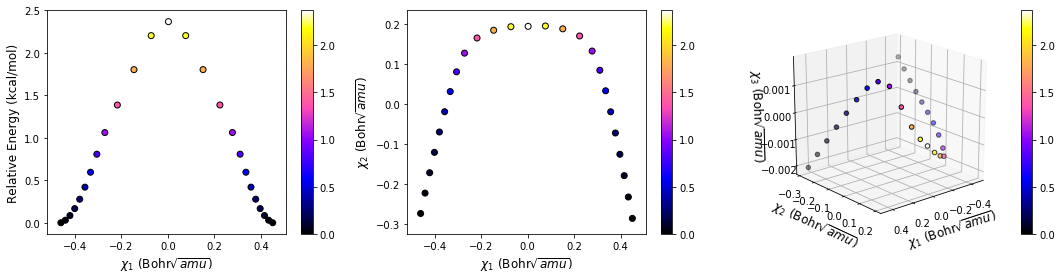

In [53]:
file='examples/malondialdehyde/malondialdehydeTS_IRC.xyz'

Old_Way(file,3)


NEW WAY: MASS WEIGHTED
File: examples/malondialdehyde/malondialdehydeTS_IRC.xyz
u shape: (25, 25)
w shape: (25,)
vh shape: (36, 36)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


Goodness of fit (1-dim)= 0.559269
Goodness of fit (2-dim)= 0.945738
Goodness of fit (3-dim)= 0.973380
Stress (3-dim) = 0.000628


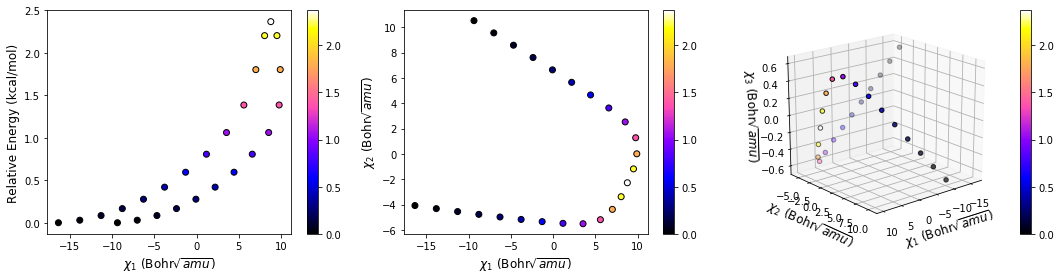

In [55]:
file='examples/SN2/'

GoF_newMW,stress_newMW=New_Way_MW(file,3)


NEW WAY: NOT MASS WEIGHTED
File: examples/malondialdehyde/malondialdehydeTS_IRC.xyz
u shape: (25, 25)
w shape: (25,)
vh shape: (36, 36)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


Goodness of fit (1-dim)= 0.686575
Goodness of fit (2-dim)= 0.949712
Goodness of fit (3-dim)= 0.979909
Stress (3-dim) = 0.000296


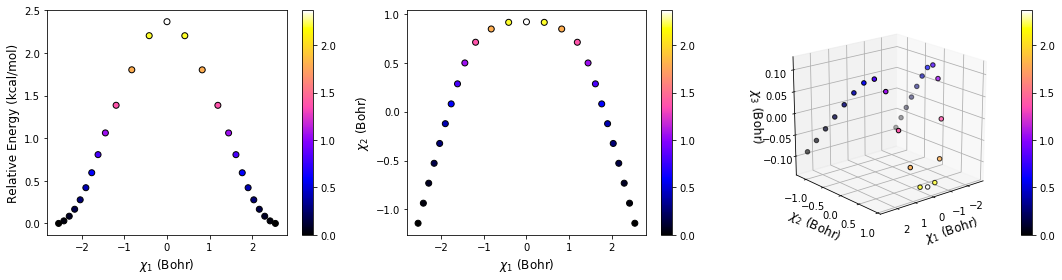

In [56]:
file = 'examples/malondialdehyde/malondialdehydeTS_IRC.xyz'
ndim = 3

GoF_new_noMW,stress_new_noMW=New_Way_noMW(file,ndim)